<a href="https://colab.research.google.com/github/nikkernoodle/shark-id/blob/models/Efficientnet_enhanced_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTS

In [54]:
#check tensorflow versions
!pip freeze | grep tensorflow

tensorflow==2.12.0
tensorflow-datasets==4.9.2
tensorflow-estimator==2.12.0
tensorflow-gcs-config==2.12.0
tensorflow-hub==0.13.0
tensorflow-io-gcs-filesystem==0.32.0
tensorflow-metadata==1.13.1
tensorflow-probability==0.20.1


In [55]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [56]:
from tensorflow.keras import layers, models, metrics, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys
import cv2
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB2, EfficientNetB3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
from sklearn.metrics import accuracy_score, balanced_accuracy_score


# PREPROCESSING

In [57]:
def load_sharks_data(loading_method):
    if loading_method == 'colab':
        data_path = '/content/drive/My Drive/shark-datasets/sharks'
    elif loading_method == 'direct':
        data_path = '../raw_data/sharks/'
    classes = {'basking': 0, 'blue': 1, 'hammerhead': 2, 'mako': 3, 'sand tiger': 4, 'tiger': 5, 'white' : 6,
               'blacktip': 7 , 'bull': 8, 'lemon':9 , 'nurse': 10, 'thresher': 11, 'whale': 12, 'whitetip': 13}
    imgs = []
    labels = []
    for (cl, i) in classes.items():
        images_path = [elt for elt in os.listdir(os.path.join(data_path, cl))]
        for img in tqdm(images_path[:300]):
            path = os.path.join(data_path, cl, img)
            if os.path.exists(path):
                image = Image.open(path)
                image = image.resize((224, 224))
                image = cv2.cvtColor(np.float32(image), cv2.COLOR_BGR2RGB)
                imgs.append(np.array(image))
                labels.append(i)

    X = np.array(imgs)
    num_classes = len(set(labels))
    y = to_categorical(labels, num_classes)

    # Finally we shuffle:
    p = np.random.permutation(len(X))
    X, y = X[p], y[p]

    first_split = int(len(imgs) /6.)
    second_split = first_split + int(len(imgs) * 0.2)
    X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
    y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]

    return X_train, y_train, X_val, y_val, X_test, y_test, num_classes

In [58]:
X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_sharks_data("colab")

100%|██████████| 125/125 [00:05<00:00, 23.57it/s]


# MODEL

## Define model

In [59]:
def load_model():

    model = EfficientNetB2(weights="imagenet", include_top=False, input_shape=X_train[0].shape)

    return model

    # tf.keras.applications.efficientnet.EfficientNetB2(
    # include_top=True,
    # weights='imagenet',
    # input_tensor=None,
    # input_shape=None,
    # pooling=None,
    # classes=1000,
    # classifier_activation='softmax',
    # **kwargs

In [60]:
model = load_model()
model.summary()

Model: "efficientnetb2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_18 (Rescaling)       (None, 224, 224, 3)  0           ['input_10[0][0]']               
                                                                                                  
 normalization_9 (Normalization  (None, 224, 224, 3)  7          ['rescaling_18[0][0]']           
 )                                                                                                
                                                                                     

In [61]:
def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    model.trainable = False

    return model

In [62]:
model = set_nontrainable_layers(model)
model.summary()

Model: "efficientnetb2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_18 (Rescaling)       (None, 224, 224, 3)  0           ['input_10[0][0]']               
                                                                                                  
 normalization_9 (Normalization  (None, 224, 224, 3)  7          ['rescaling_18[0][0]']           
 )                                                                                                
                                                                                     

### Actually build the model

In [63]:
def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    # $CHALLENGIFY_BEGIN
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer1 = layers.Dense(500, activation='relu')
    dropout_layer1 = layers.Dropout(0.3)
    dense_layer2 = layers.Dense(400, activation='relu')
    dropout_layer2 = layers.Dropout(0.3)
    dense_layer3 = layers.Dense(300, activation='relu')
    dropout_layer3 = layers.Dropout(0.3)
    prediction_layer = layers.Dense(14, activation='softmax')
#creating dense layer 1 (changed from 50 to 500), dense layer 2 (400) and dense layer 3 (300) and dropout layers

    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer1,
        dropout_layer1,
        dense_layer2,
        dropout_layer2,
        dense_layer3,
        dropout_layer3,
        prediction_layer
    ])
    # $CHALLENGIFY_END
    return model

In [64]:
model = add_last_layers(model)
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 7, 7, 1408)       7768569   
                                                                 
 flatten_9 (Flatten)         (None, 68992)             0         
                                                                 
 dense_36 (Dense)            (None, 500)               34496500  
                                                                 
 dropout_23 (Dropout)        (None, 500)               0         
                                                                 
 dense_37 (Dense)            (None, 400)               200400    
                                                                 
 dropout_24 (Dropout)        (None, 400)               0         
                                                                 
 dense_38 (Dense)            (None, 300)              

## Compile EfficientnetB2 + layers

In [65]:
# from sklearn.model_selection import GridSearchCV
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# # Define the hyperparameters and their values to search
# param_grid = {
#     'optimizer': ['adam', 'sgd'],
#     'units': [16, 32, 64]
# }
# model = build_model()

# model_grid = KerasClassifier(model=model, epochs=10, batch_size=16)

# grid = GridSearchCV(estimator=model_grid, param_grid=param_grid, cv=3)
# #grid_result = grid.fit(X_train, y_train)

# #model_grid.get_params()

In [66]:
def build_model():

    model = load_model()
    model = add_last_layers(model)

    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  weighted_metrics=['accuracy'])

    return model


## Fit the model

In [67]:
model = build_model()
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 7, 7, 1408)       7768569   
                                                                 
 flatten_10 (Flatten)        (None, 68992)             0         
                                                                 
 dense_40 (Dense)            (None, 500)               34496500  
                                                                 
 dropout_26 (Dropout)        (None, 500)               0         
                                                                 
 dense_41 (Dense)            (None, 400)               200400    
                                                                 
 dropout_27 (Dropout)        (None, 400)               0         
                                                                 
 dense_42 (Dense)            (None, 300)             

In [68]:
model = build_model()

es = EarlyStopping(monitor = 'val_accuracy',
                   mode = 'max',
                   patience = 20,
                   verbose = 1,
                   restore_best_weights = True)
#patience changes from 5 to 20
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=16,
                    callbacks=[es])
#patience changes from 50 to 100
#batch_size changed from 16 to 32

Epoch 1/100
62/62 [==============================] - 19s 134ms/step - loss: 2.7693 - accuracy: 0.1853 - val_loss: 1.8513 - val_accuracy: 0.4239
Epoch 2/100
62/62 [==============================] - 5s 80ms/step - loss: 2.0366 - accuracy: 0.3452 - val_loss: 1.7071 - val_accuracy: 0.4401
Epoch 3/100
62/62 [==============================] - 5s 80ms/step - loss: 1.7010 - accuracy: 0.4348 - val_loss: 1.4188 - val_accuracy: 0.5566
Epoch 4/100
62/62 [==============================] - 5s 78ms/step - loss: 1.3835 - accuracy: 0.5316 - val_loss: 1.3060 - val_accuracy: 0.5566
Epoch 5/100
62/62 [==============================] - 5s 80ms/step - loss: 1.2611 - accuracy: 0.5957 - val_loss: 1.1592 - val_accuracy: 0.6343
Epoch 6/100
62/62 [==============================] - 5s 75ms/step - loss: 0.9985 - accuracy: 0.6670 - val_loss: 1.0860 - val_accuracy: 0.6667
Epoch 7/100
62/62 [==============================] - 5s 81ms/step - loss: 0.8538 - accuracy: 0.7098 - val_loss: 1.0098 - val_accuracy: 0.6570
Epoc

### Plot accuracy

In [69]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

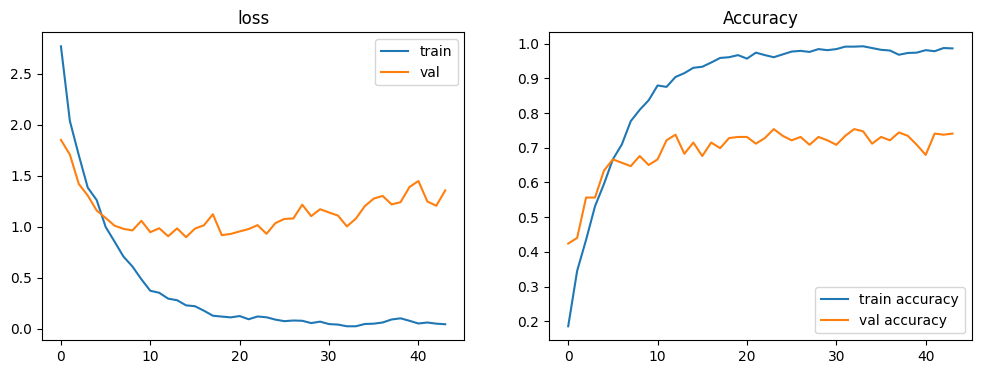

In [70]:
plot_history(history)

In [71]:
#overall accuarcy

res_vgg = model.evaluate(X_test, y_test)

test_accuracy_vgg = res_vgg[-1]


print(f"test_accuracy_vgg = {round(test_accuracy_vgg,2)*100} %")

# print(f"test_accuracy = {round(test_accuracy,2)*100} %")

print(f'Chance level: {1./num_classes*100:.1f}%')


9/9 [==============================] - 2s 173ms/step - loss: 0.8797 - accuracy: 0.7403
test_accuracy_vgg = 74.0 %
Chance level: 7.1%


In [72]:
predictions = model.predict(X_test)

9/9 [==============================] - 3s 90ms/step


In [73]:
y_pred = []

for pred in predictions:
  y_pred.append(np.argmax(pred))

In [74]:
y_test_argmax = []
for test in y_test:
  y_test_argmax.append(np.argmax(test))

### Classification Report for each class and overall

#### Create accuracy metric

In [75]:
# Return macro accuracy
accuracy = accuracy_score(y_test_argmax, y_pred)

# Return weighted accuracy
accuracy_bal = balanced_accuracy_score(y_test_argmax, y_pred)

accuracy, accuracy_bal

(0.7403100775193798, 0.7200918157704906)

In [76]:
from sklearn.metrics import classification_report
from sklearn import datasets, svm, metrics

In [77]:
#classification report

labels=['basking', 'blue', 'hammerhead', 'mako', 'sand tiger', 'tiger', 'white', 'blacktip', 'bull', 'lemon', 'nurse', 'thresher', 'whale', 'whitetip']

report = classification_report(y_test_argmax, y_pred, target_names=labels, output_dict=True)

# Convert the report to a pandas DataFrame
df = pd.DataFrame(report).transpose()
df = df.sort_values(by='precision', ascending=False)
df.reset_index(inplace=True)
df

,index,precision,recall,f1-score,support
0,tiger,1.000000,0.764706,0.866667,17.00000
1,whale,1.000000,0.913043,0.954545,23.00000
2,hammerhead,0.906250,0.906250,0.906250,32.00000
3,basking,0.818182,1.000000,0.900000,18.00000
4,nurse,0.800000,0.888889,0.842105,9.00000
5,sand tiger,0.800000,0.615385,0.695652,13.00000
6,mako,0.777778,0.583333,0.666667,12.00000
7,weighted avg,0.761128,0.740310,0.733440,258.00000
8,macro avg,0.753271,0.720092,0.718026,258.00000
9,accuracy,0.740310,0.740310,0.740310,0.74031


### Confusion Matrix for class analysis

In [78]:
cm = confusion_matrix(y_test_argmax, y_pred)

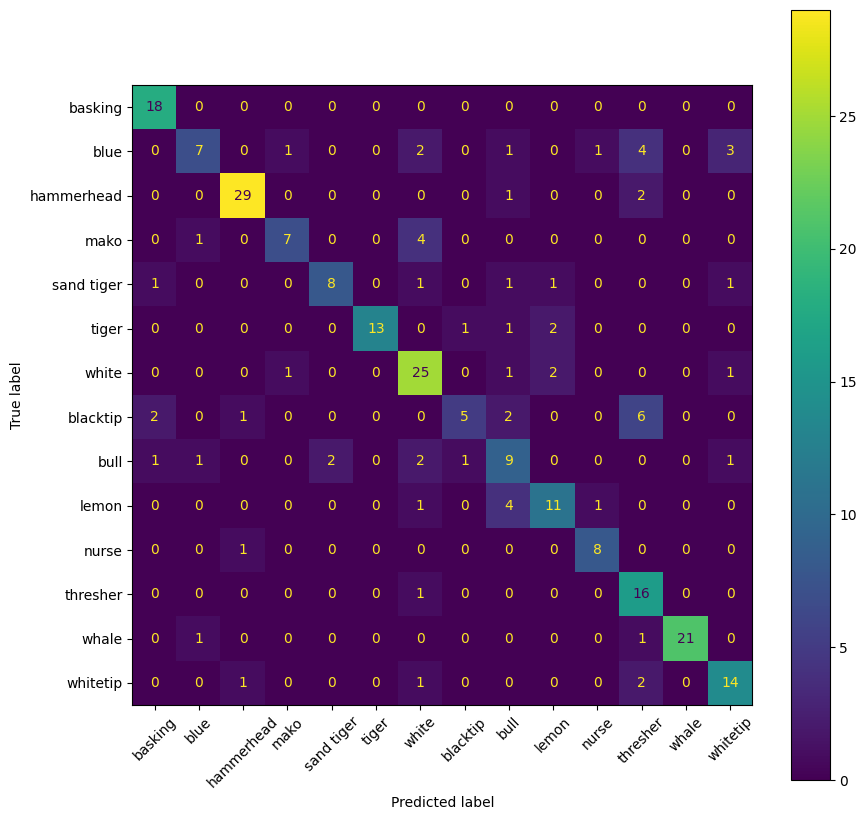

In [79]:
shark_labels = ['basking', 'blue', 'hammerhead', 'mako', 'sand tiger', 'tiger', 'white', 'blacktip', 'bull', 'lemon', 'nurse', 'thresher', 'whale', 'whitetip']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=shark_labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
ax.set_xticklabels(shark_labels, rotation=45)

plt.show()